In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import stream as st
import matplotlib.pyplot as plt

import os
import sys
import logging

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
adata_infile = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/bcell_magic_imputed_subset.h5ad"

In [3]:
!rsync -aP $adata_infile /dev/shm/

sending incremental file list
bcell_magic_imputed_subset.h5ad
  1,268,574,815 100%  433.92MB/s    0:00:02 (xfr#1, to-chk=0/1)


# Run stream dim reduction on the anndata, with imputed gene expression
### Use stream

#### prep files

In [4]:
#read the stream result file pkl
adata=st.read(file_name='/dev/shm/bcell_magic_imputed_subset.h5ad', workdir='/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs')

Saving results in: /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs


In [5]:
adata

AnnData object with n_obs × n_vars = 24315 × 3025
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'DM_EigenValues', 'cell_type_major_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sub_cell_type_colors', 'topic_dendogram', 'umap', 'workdir'
    obsm: 'DM_EigenVectors', 'X_joint_umap

## Stream steps

In [6]:
#set the imputed gene expression as the accessible data layer
adata.X = adata.layers['MAGIC_imputed_data'] # does not load into variable gene selection, scaled data loads

Saving results in: /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs
152 variable genes are selected


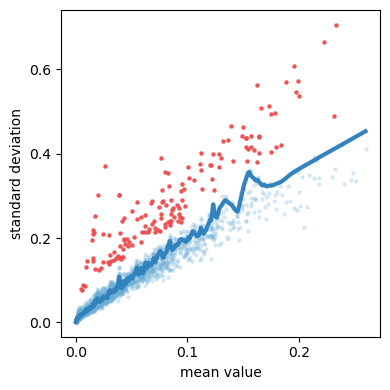

In [7]:
import stream as st
st.set_workdir(adata,'/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs')
st.select_variable_genes(adata,loess_frac=0.01,percentile=95)

#### Run dimension reduction on original 3025 genes as they are already selected for being highly variable

In [8]:
st.dimension_reduction(adata,method='se',feature='var_genes',n_components=2,n_neighbors=30,n_jobs=120) # using the same knn as diffusion maps

feature var_genes is being used ...
120 cpus are being used ...


#### Order cell types based on how you think the pseudotime should be

In [9]:
import pandas as pd
adata.obs['sub_cell_type'] = pd.Categorical(
    adata.obs['sub_cell_type'],
    categories=['10_UD_0','1_ABC','11_UD_3','4_Day 3 cells','2_UD_4','8_UD_2','3_GC','6_MBC from GC','9_UD_1','7_PB'],
    ordered=True
)

In [10]:
print(adata.obsm.keys())

KeysView(AxisArrays with keys: DM_EigenVectors, X_joint_umap_features, X_pca, X_topic_compositions, X_umap, X_umap_features, var_genes, X_se, X_dr)


In [11]:
print(adata.uns['sub_cell_type_colors'])

['#ff7f0e' '#279e68' '#d62728' '#aa40fc' '#e377c2' '#b5bd61' '#17becf'
 '#aec7e8' '#ffbb78' '#98df8a']


In [12]:
# Create a custom dictionary mapping sub_cell_types to colors
color_dict = {
    '1_ABC': '#FF7F00',    # Orange
    '2_UD_4': '#006400',   # Dark green
    '3_GC': '#D62728',     # Red
    '4_Day 3 cells': '#9467BD',  # Purple
    '6_MBC from GC': '#E377C2',  # Pink
    '7_PB': '#808000',     # Olive Green
    '8_UD_2': '#17BECF',   # Cyan
    '9_UD_1': '#87CEEB',   # Sky Blue
    '10_UD_0': '#FFE4B5',  # Very Light Orange
    '11_UD_3': '#D3D3D3'   # Light Gray
}

# Add a new column to obs with the color for each cell
adata.obs['sub_cell_type_colors'] = adata.obs['sub_cell_type'].map(color_dict)

# Verify the new column
print(adata.obs[['sub_cell_type', 'sub_cell_type_colors']].head())

                   sub_cell_type sub_cell_type_colors
AAACAGCCAAGCCACT-3          3_GC              #D62728
AAACAGCCAAGGTGCA-1         1_ABC              #FF7F00
AAACAGCCAATTATGC-2        8_UD_2              #17BECF
AAACAGCCATTCAGCA-3          3_GC              #D62728
AAACATGCAAAGCTCC-1         1_ABC              #FF7F00


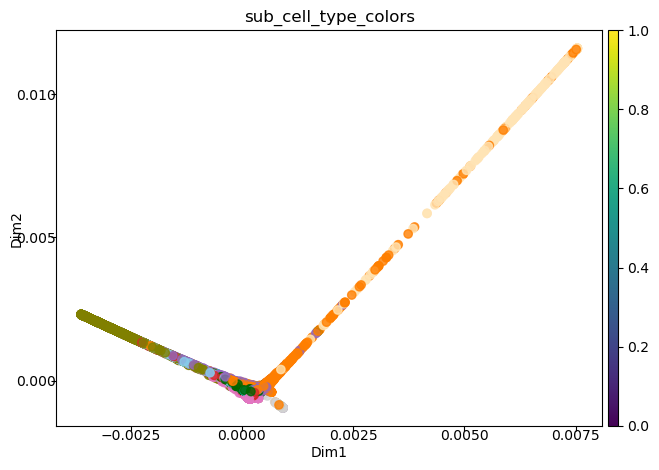

In [13]:
st.plot_dimension_reduction(adata,color=['sub_cell_type_colors'],n_components=2)

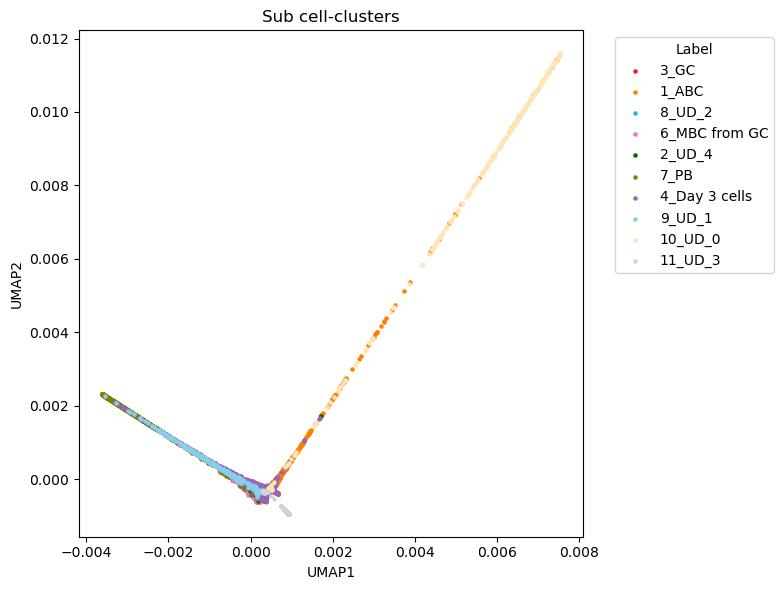

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot (assuming this contains UMAP data)
umap_coords = adata.obsm['X_dr']

# Extract the labels for coloring
labels = adata.obs['sub_cell_type']

# Get unique labels and their corresponding colors
unique_labels = labels.unique()
color_list = [color_dict[label] for label in unique_labels]

# Plotting the UMAP with colors based on labels
plt.figure(figsize=(8, 6))

for label, color in zip(unique_labels, color_list):
    idx = labels == label
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=color, label=label, s=5)  # s=5 sets the marker size to 5 points

plt.title('Sub cell-clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Trajectory inference by fitting elastic graph

In [12]:
import os
os.environ["OMP_NUM_THREADS"] = "64"
from tempfile import TemporaryDirectory
from rpy2.robjects import r
# Load the rlang package in R
r('library(rlang)')

# Parameters for STREAM (tune to your dataset)
ka1={'epg_alpha':0.02,'epg_mu':0.07,'epg_lambda':0.02,'epg_trimmingradius':2} # epg_mu needs to be tuned to get a good branch for day-1 to activated and undefined cells
ka2={'epg_ext_mode':'QuantDists','epg_ext_par':1.}

# Trajectory inference
with TemporaryDirectory() as td:
	st.set_workdir(adata,td)
	st.seed_elastic_principal_graph(adata,n_clusters=10)
	st.elastic_principal_graph(adata,**ka1)
	st.extend_elastic_principal_graph(adata,**ka2)
	

Saving results in: /tmp/tmpc3urm1bh
Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...
Number of initial branches: 3
Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 28236 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||50
	
1.044e-07
	
50
	
49
	
46
	
1
	
0
	
0
	
4.388e-08
	
4.067e-08
	
0.9913
	
0.992
	
5.581e-08
	
4.692e-09
	
2.346e-07
	
1.173e-05
	
0




/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

  warnings.warn(x, RRuntimeWarning)


73.939 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 3
Extending leaves with additional nodes ...
Number of branches after extending leaves: 3


In [40]:
st.optimize_branching(adata,incr_n_nodes=30) #smoothen out the day-1 to activated to undefined cell branch

Optimizing branching...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 83 nodes on 28236 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
53
 
54
 
55
 
56
 
57
 
58
 
59
 
60
 
61
 
62
 
63
 
64
 
65
 
66
 
67
 
68
 
69
 
70
 
71
 
72
 
73
 
74
 
75
 
76
 
77
 
78
 
79
 
80
 
81
 
82
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||83
	
7.39e-08
	
83
	
82
	
79
	
1
	
0
	
0
	
3.436e-08
	
3.266e-08
	
0.9932
	
0.9935
	
3.681e-08
	
2.73e-09
	
2.266e-07
	
1.881e-05
	
0


10.102 sec elapsed

Number of branches after optimizing branching: 3


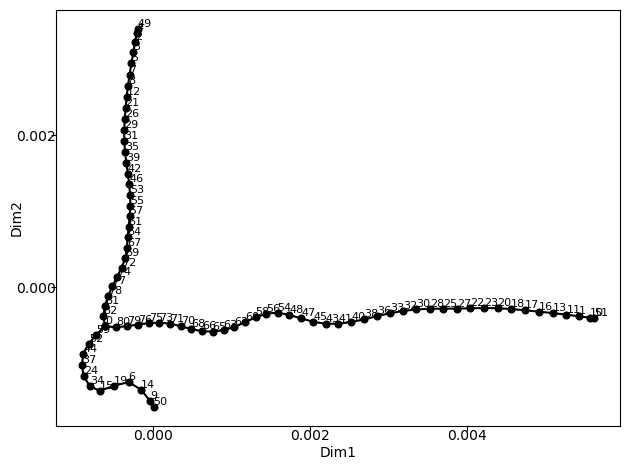

In [45]:
st.plot_branches(adata,show_text=True)

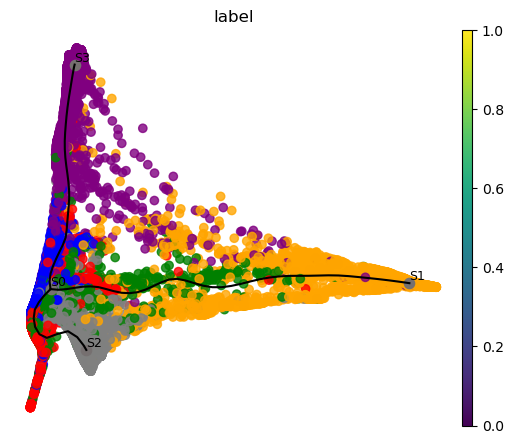

In [46]:
import matplotlib.pyplot as plt

st.plot_dimension_reduction(adata,show_graph=True,show_text=True,color=['label'])
ax=plt.gca()
ax.set_aspect(1)
ax.axis('off');


Extending leaves with additional nodes ...
Number of branches after extending leaves: 3


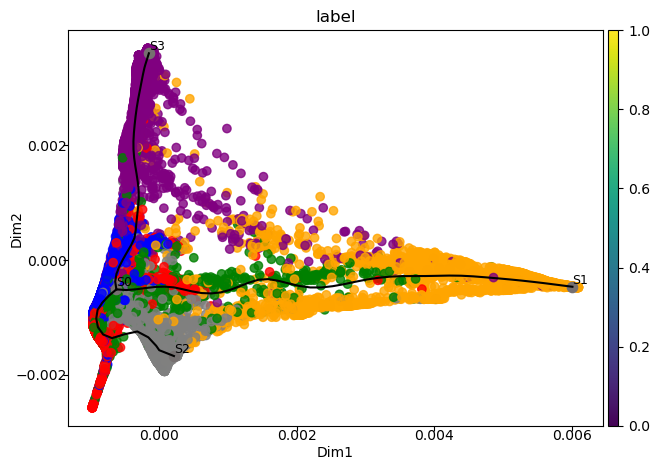

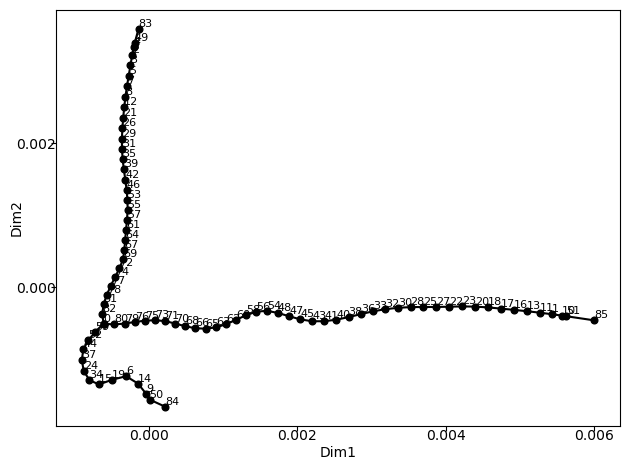

In [47]:
###Extend leaf branch to reach further cells 
st.extend_elastic_principal_graph(adata, epg_ext_mode='WeigthedCentroid',epg_ext_par=0.8)
st.plot_dimension_reduction(adata,color=['label'],n_components=2,show_graph=True,show_text=True)
st.plot_branches(adata,show_text=True)

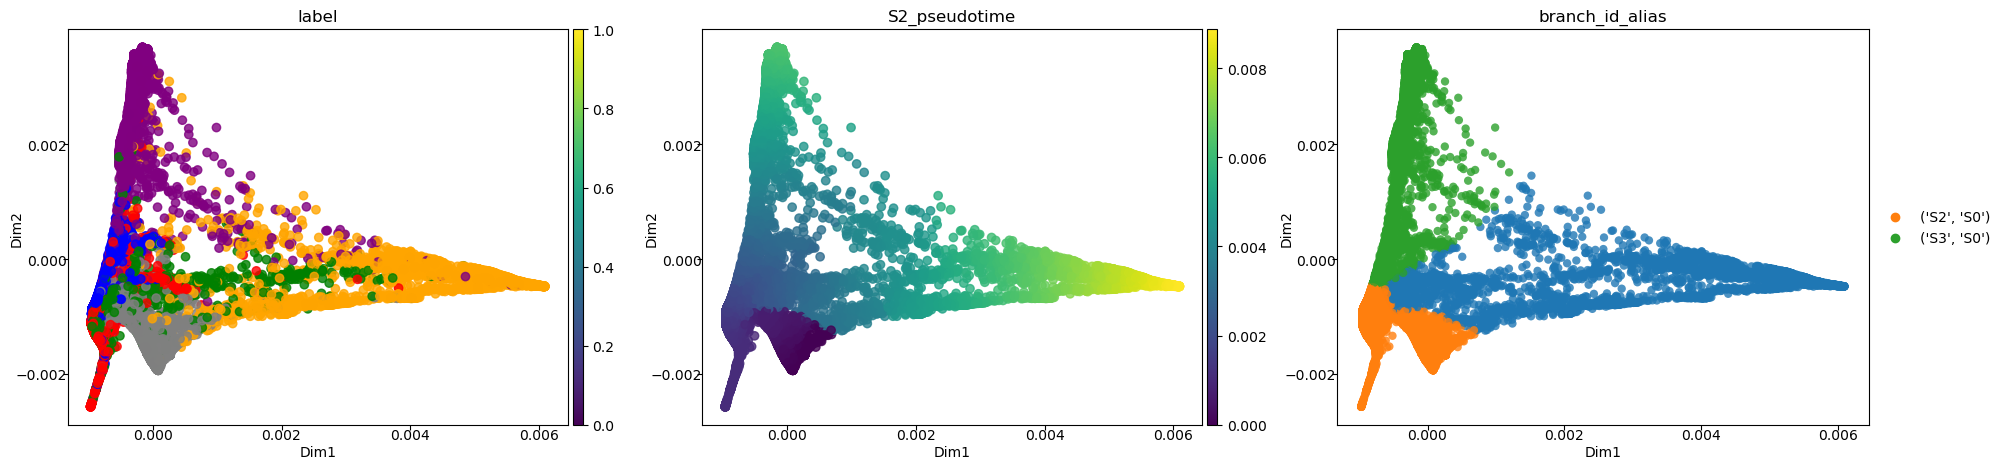

In [48]:
#Replace S3 with your own starting node if on a different dataset
st.plot_dimension_reduction(adata,color=['label','S2_pseudotime','branch_id_alias'])


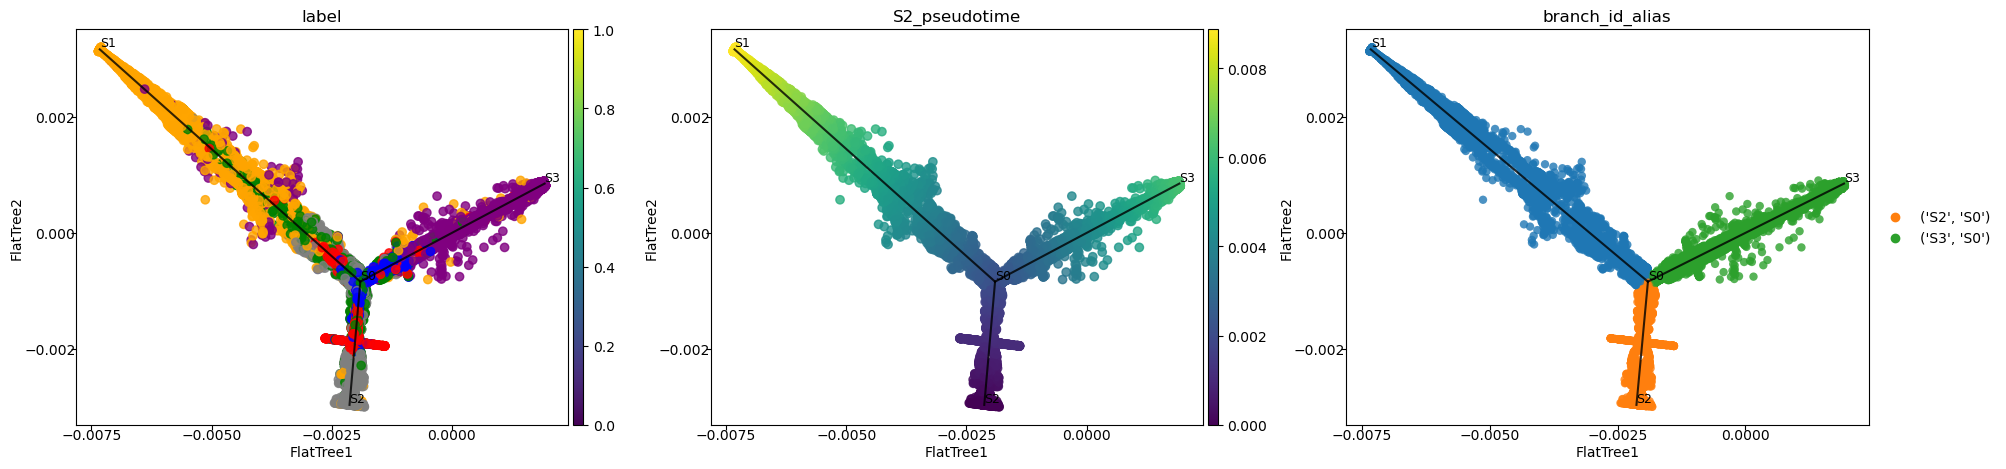

In [50]:
st.plot_flat_tree(adata,color=['label','S2_pseudotime','branch_id_alias'],
                  dist_scale=0.5,show_graph=True,show_text=True)

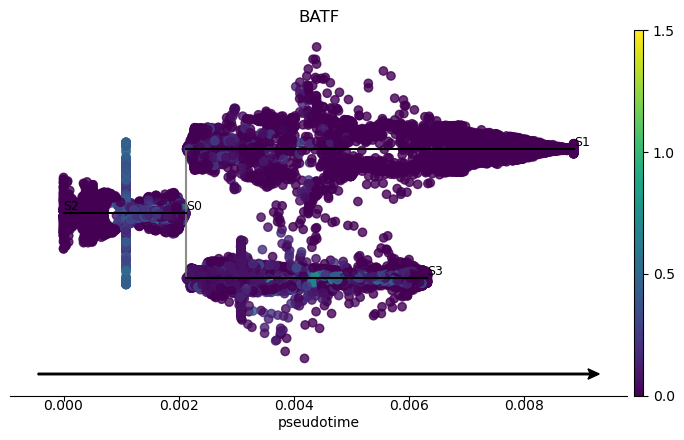

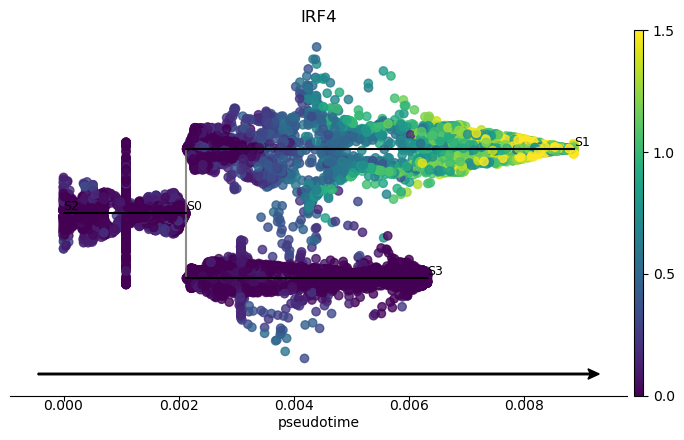

In [8]:
st.plot_stream_sc(adata,root='S2',color=['BATF','IRF4'], vmin=0, vmax=1.5,dist_scale=0.3,show_graph=True,show_text=True)

In [55]:
adata.obs.head()

,cell_type_major,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,topic_0,topic_1,topic_2,topic_3,...,node,branch_id,branch_id_alias,branch_lam,branch_dist,kmeans,S0_pseudotime,S3_pseudotime,S2_pseudotime,S1_pseudotime
AAACAGCCAAGCCACT-3,day5_6,3582,3580,8281.0,846.0,10.216157,0.018575,0.013160,0.008065,0.036125,...,4,"(83, 0)","(S3, S0)",0.000259,0.000092,cluster 8,0.003930,0.000259,0.006064,0.010666
AAACAGCCAAGGTGCA-1,day0_2,2416,2415,4951.0,471.0,9.513230,0.038631,0.025551,0.318661,0.011544,...,24,"(84, 0)","(S2, S0)",0.001405,0.000060,cluster 3,0.000728,0.004918,0.001405,0.007464
AAACAGCCAAGTTATC-1,day0_2,1435,1435,2449.0,216.0,8.819926,0.015908,0.023365,0.006621,0.007612,...,76,"(85, 0)","(S1, S0)",0.006277,0.000115,cluster 0,0.000459,0.004648,0.002593,0.006277
AAACAGCCAATAGCCC-1,day0_2,1349,1349,2316.0,138.0,5.958549,0.011711,0.010980,0.044246,0.010271,...,37,"(84, 0)","(S2, S0)",0.001581,0.000030,cluster 5,0.000553,0.004742,0.001581,0.007288
AAACAGCCAGTTAGCC-1,day0_2,2019,2017,3779.0,257.0,6.800741,0.016863,0.013082,0.135453,0.012727,...,44,"(84, 0)","(S2, S0)",0.001639,0.000051,cluster 5,0.000495,0.004684,0.001639,0.007230


In [59]:
# Extract node names from pseudotime columns
import numpy as np
import pandas as pd

dimnodes=np.array(sorted([x[:-len('_pseudotime')] for x in adata.obs.columns if x.endswith('_pseudotime')]))
# Create a distance matrix between cells and nodes (cell by node, value is pseudotime distance)
dist=np.array([adata.obs.loc[adata.obs.index,x+'_pseudotime'].values for x in dimnodes]).T
node_dict=dict(zip(dimnodes,range(len(dimnodes))))

# Map branch_id_alias to numeric indices based on node names
branch = np.array([
    sorted([node_dict.get(y.strip('() \''), None) for y in x])
    for x in adata.obs['branch_id_alias']
])
# The branch each cell is on (cell:(node_start,node_end))
branch=pd.DataFrame(branch,index=adata.obs.index)
branch.to_csv('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/branch.tsv.gz',header=False,index=False,sep='\t')

# Identify and save unique edges between nodes
edge=np.unique(branch.values,axis=0)
edge=pd.DataFrame(edge)
edge.to_csv('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/edge.tsv.gz',header=False,index=False,sep='\t')

dist=pd.DataFrame(dist,index=adata.obs.index,columns=dimnodes)
dist.to_csv('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/dist.tsv.gz',header=True,index=True,sep='\t')


In [60]:
st.write(adata,file_name='/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/stream_result.pkl')

#### Make subsets of the merged cell clusters

In [ ]:
dictys_data_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/data'
adata.obs.leiden_merged.to_csv(f'{dictys_data_path}/clusters.csv',header=['Cluster'],index=True,index_label='Barcode')

#### Make coord_rna.tsv.gz file of the cells and their lower dim coords

In [ ]:
import anndata as ad
import pandas as pd

# Convert the obs.index (cell barcodes) to a DataFrame
obs_index_df = pd.DataFrame(adata.obs.index)
# Create a new AnnData object with only the cell barcodes and X_dr from obsm
adata_reduced = ad.AnnData(
    obs=obs_index_df,  # Use the cell barcodes as the obs DataFrame
    obsm={"X_dr": adata.obsm['X_dr']}  # Keep only 'X_dr' from obsm
)
# Confirm that the new AnnData object has the correct structure
adata_reduced

In [ ]:
# checking how tutorial files look like
import pandas as pd
# inspect pre-existing coord file to dave anndata in the dame format
coord_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/tut_files/skin_data/coord_rna.tsv.gz'
coord_df = pd.read_csv(coord_file, sep='\t', compression='gzip')
# Display the first few rows of the DataFrame
print(coord_df.head())

In [ ]:
import os
import pandas as pd

# Extract the relevant columns from the AnnData object
# The cell barcodes (obs.index) and 'X_dr' from obsm
cell_barcodes = adata.obs.index
xy_coords = adata_reduced.obsm['X_dr']

# Create a DataFrame with cell barcodes as the first column and 'X_dr' as the next columns
coord_df_b_cell = pd.DataFrame(data=xy_coords, columns=['x', 'y'])
coord_df_b_cell.insert(0, None, cell_barcodes)

#display the df
print(coord_df_b_cell.head())

In [ ]:
# Save the DataFrame to a TSV file
output_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/data/coord_rna.tsv.gz'
coord_df_b_cell.to_csv(output_path, sep='\t', compression='gzip', index=False, header=['', 'x', 'y'])

In [ ]:
# read the saved anndata
import anndata as ad
adata = ad.read_h5ad(adata_outfile)